In [1]:
import train as train
import generate
import eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pyro

In [2]:
BASE_DIR = "./tests/sanity_check"
PROFILE = "sinus-(10,20)-adam"

#BASE_DIR = "./tests/x-dim-test"
#PROFILE = "test"

In [3]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile prodlin-(10,20)-50k ======


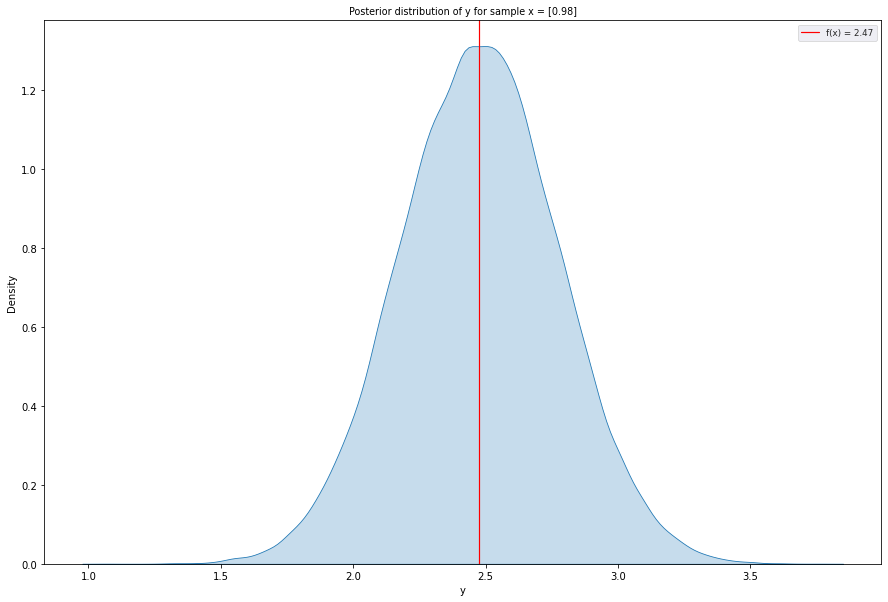

In [4]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [5]:
(x_train, y_train), _, (x_test, y_test), (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)

In [6]:
x_test[0], y_test[0]

(tensor([6.3223]), tensor(1.3995))

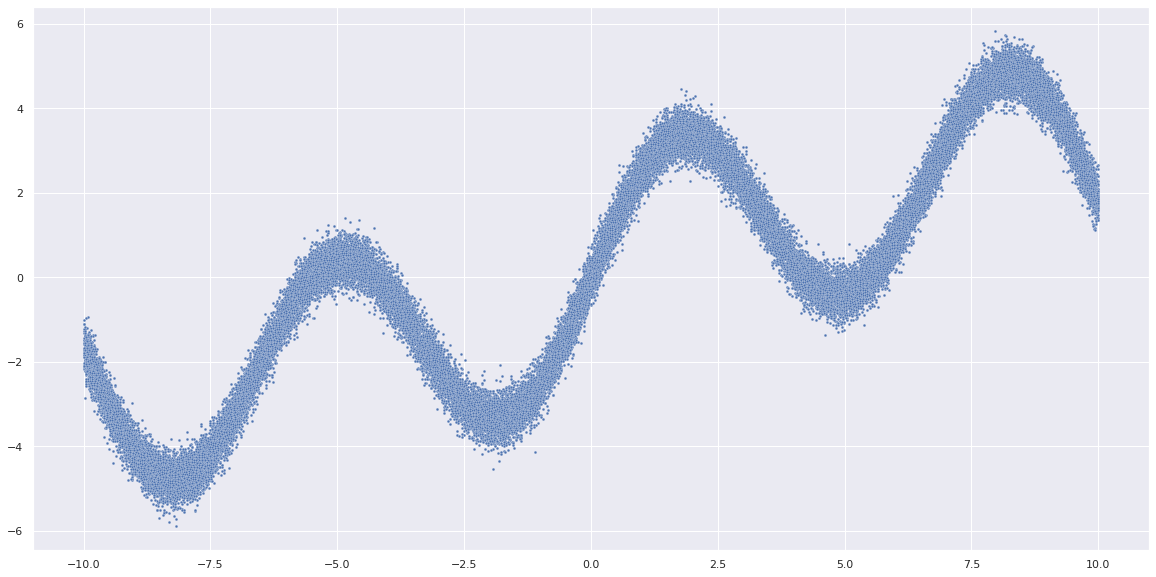

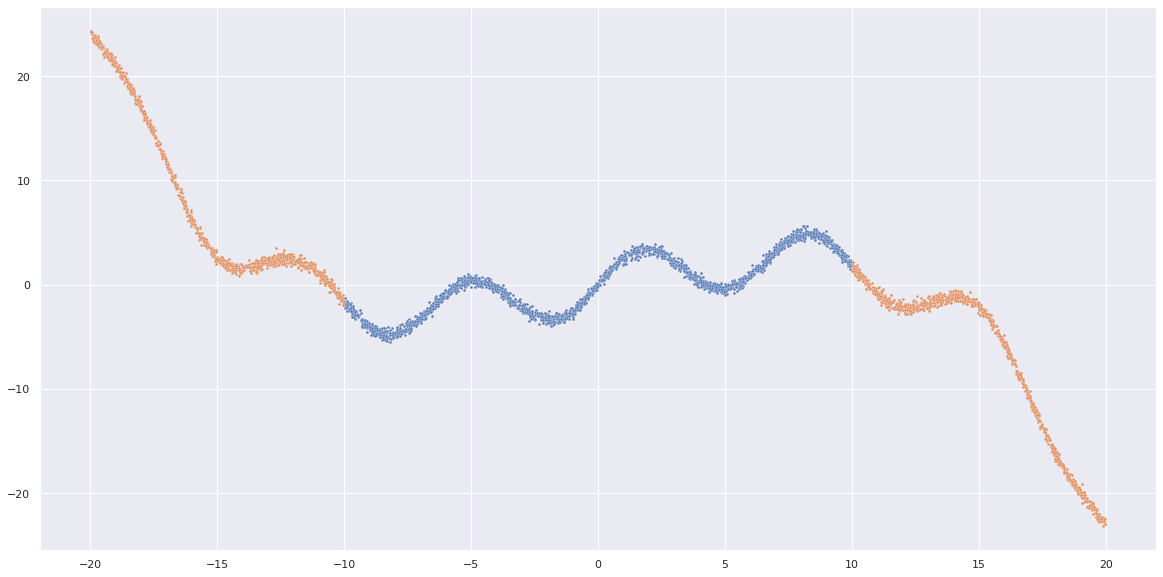

In [7]:
sns.set(rc = {'figure.figsize':(20,10)})
fig, ax = plt.subplots(1, 1)
sns.scatterplot(x=x_train.flatten(), y=y_train, s=8, ax=ax)
plt.show()
fig, ax = plt.subplots(1, 1)
sns.scatterplot(x=x_test_in_domain.flatten(), y=y_test_in_domain, s=8, ax=ax)
sns.scatterplot(x=x_test_out_domain.flatten(), y=y_test_out_domain, s=8, ax=ax)
plt.show()


In [8]:
pyro.clear_param_store()

if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    infer_model = train.train(config, dataset_config, f"{BASE_DIR}")

AutoDelta()
Using device: cpu
===== Training profile prodlin-(10,20)-delta =====


Epoch:   0%|          | 0/800 [00:00<?, ?it/s]

Training finished in 0:13:28.046684 seconds


In [9]:
#inference_model = eval.load_model(BASE_DIR, config)
inference_model = infer_model

In [10]:
predictive = inference_model.get_predictive(num_predictions=500)
train_samples = predictive(x_train)
train_samples.keys()
test_samples = predictive(x_test)


In [11]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

train_pred_summary = summary(train_samples)
test_pred_summary = summary(test_samples)

In [12]:
train_y = train_pred_summary["obs"]
train_mu = train_pred_summary["_RETURN"]
train_predictions = pd.DataFrame({
    "x": x_train.flatten(),
    "mu": train_mu["mean"].flatten(),
    "mu_5": train_mu["5%"].flatten(),
    "mu_95": train_mu["95%"].flatten(),
    "y_mean": train_y["mean"].flatten(),
    "y_5": train_y["5%"].flatten(),
    "y_95": train_y["95%"].flatten(),
    "true_y": y_train.flatten()
})

test_y = test_pred_summary["obs"]
test_mu = test_pred_summary["_RETURN"]
test_predictions = pd.DataFrame({
    "x": x_test.flatten(),
    "mu": test_mu["mean"].flatten(),
    "mu_5": test_mu["5%"].flatten(),
    "mu_95": test_mu["95%"].flatten(),
    "y_mean": test_y["mean"].flatten(),
    "y_5": test_y["5%"].flatten(),
    "y_95": test_y["95%"].flatten(),
    "true_y": y_test.flatten()
})


In [13]:
train_predictions.head()

,x,mu,mu_5,mu_95,y_mean,y_5,y_95,true_y
0,0.976270,2.512319,2.512319,2.512319,2.519742,1.977900,3.090544,2.359286
1,4.303787,0.086025,0.086025,0.086025,0.128259,-0.395729,0.691726,-0.116441
2,2.055268,3.327156,3.327156,3.327156,3.326323,2.757673,3.864951,3.094327
3,0.897664,2.390577,2.390577,2.390577,2.407603,1.826881,2.960903,2.583142
4,-1.526904,-3.230755,-3.230756,-3.230756,-3.232338,-3.800664,-2.652354,-3.144912


In [14]:
train_pred_sorted = train_predictions.sort_values(by='x')
test_pred_sorted = test_predictions.sort_values(by='x')

def plot_predictions(summary, SAVE_PATH=None):
    sns.set(rc = {'figure.figsize':(25,12)})
    fig, ax = plt.subplots()

    ax.set_title("Posterior predictive distribution with 95% CI")
    sns.lineplot(x=summary['x'], y=summary['mu'], ax=ax, color='red')
    ax.fill_between(x=summary['x'], y1=summary['mu_5'], y2=summary['mu_95'], alpha=0.3, color='green')
    sns.scatterplot(x=summary['x'], y=summary['true_y'], ax=ax, alpha=0.7, size=0.5, legend=False)
    
    sns.set(rc = {'figure.figsize':(25,12)})
    fig, ax = plt.subplots()

    ax.set_title("Posterior predictive distribution with 95% CI")
    sns.lineplot(x=summary['x'], y=summary['y_mean'], ax=ax, color='red')
    ax.fill_between(x=summary['x'], y1=summary['y_5'], y2=summary['y_95'], alpha=0.3, color='green')
    sns.scatterplot(x=summary['x'], y=summary['true_y'], ax=ax, alpha=0.7, size=0.5, legend=False)

    if SAVE_PATH:
        plt.savefig(SAVE_PATH)

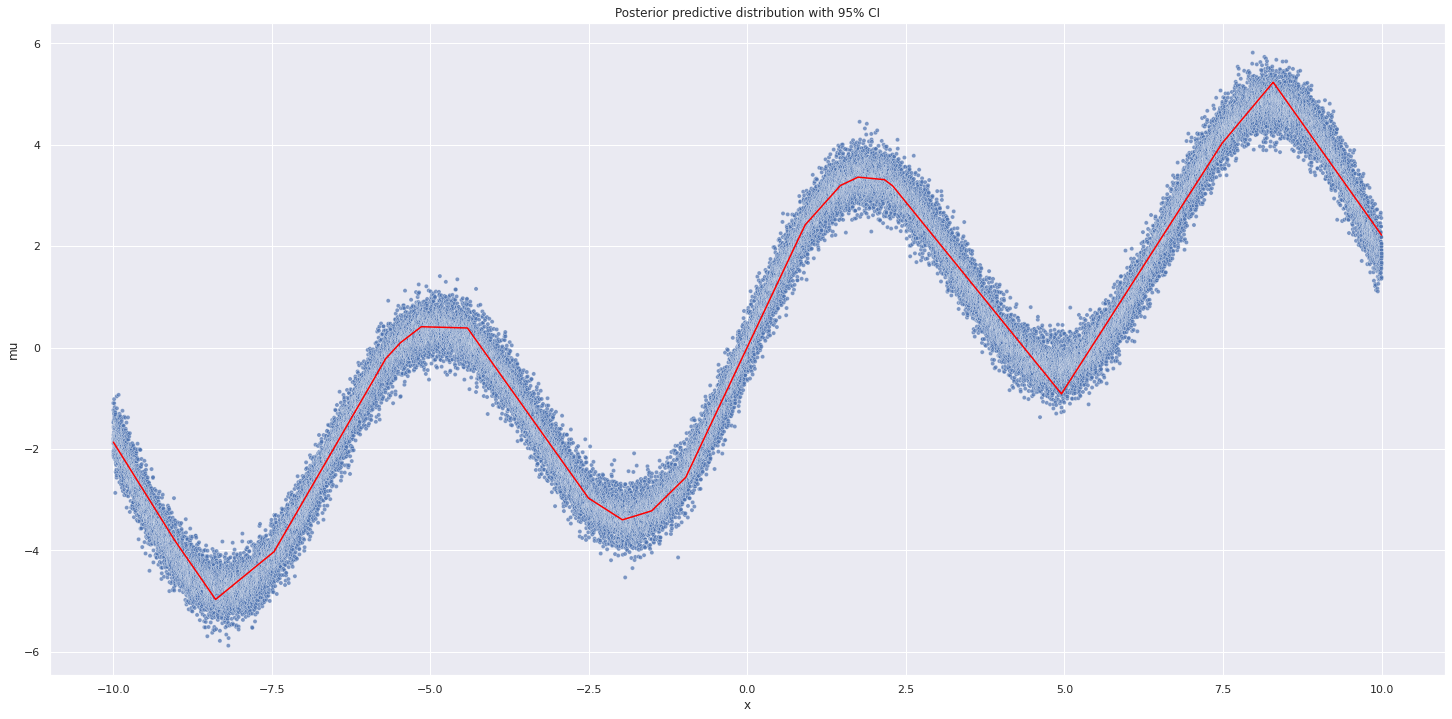

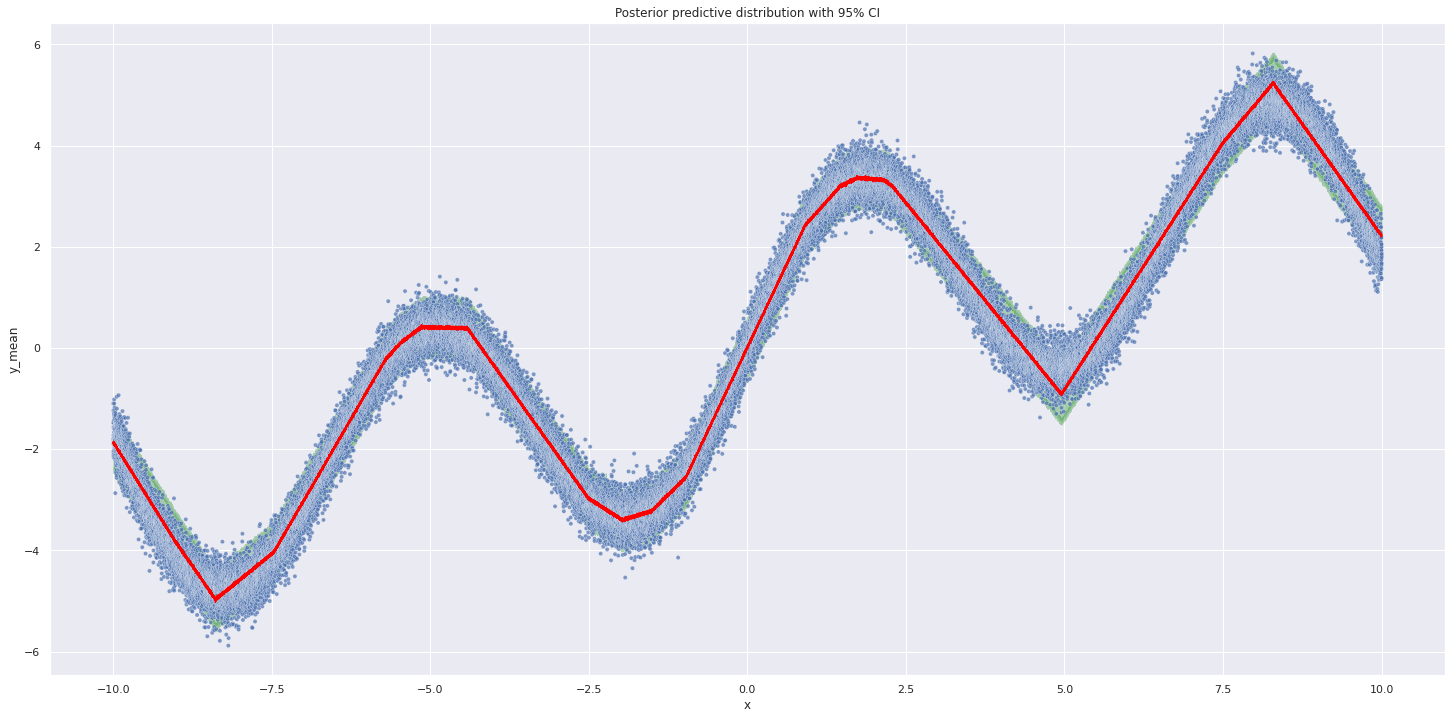

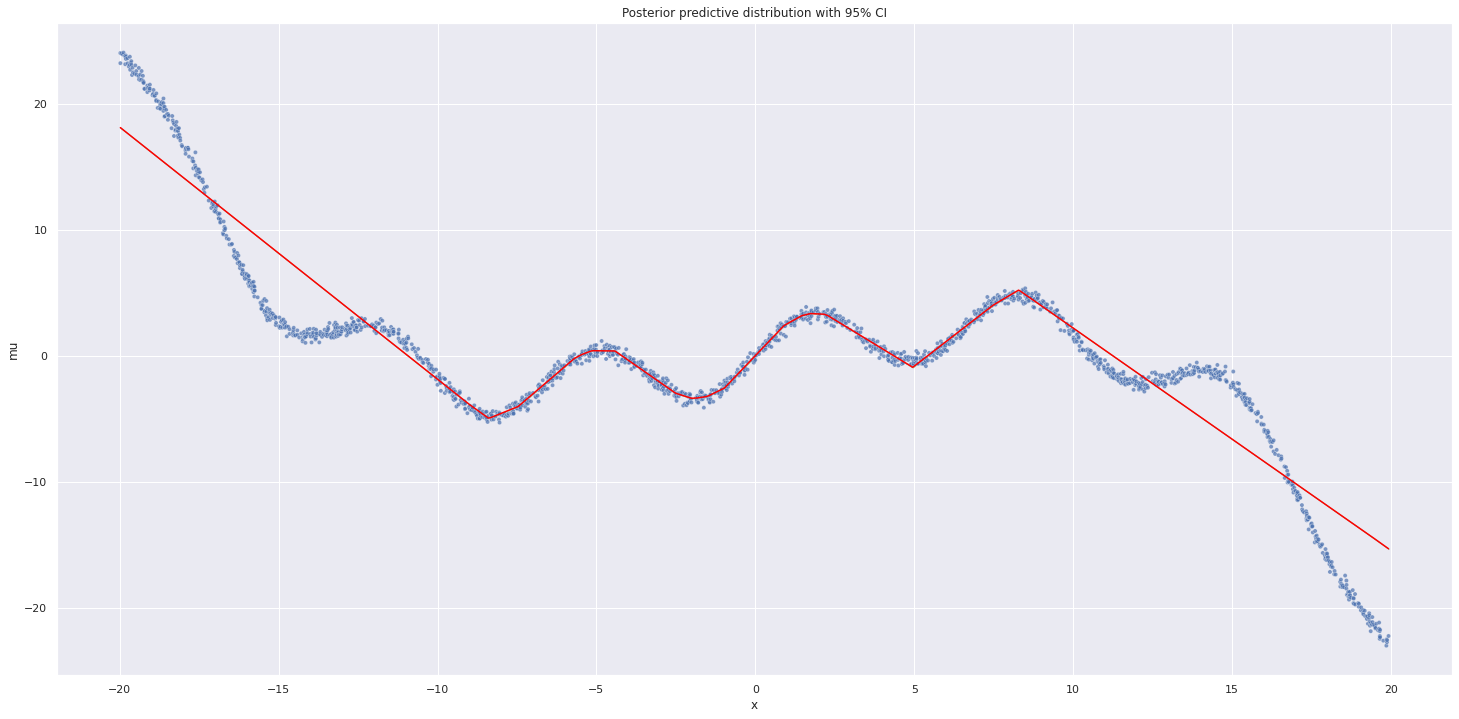

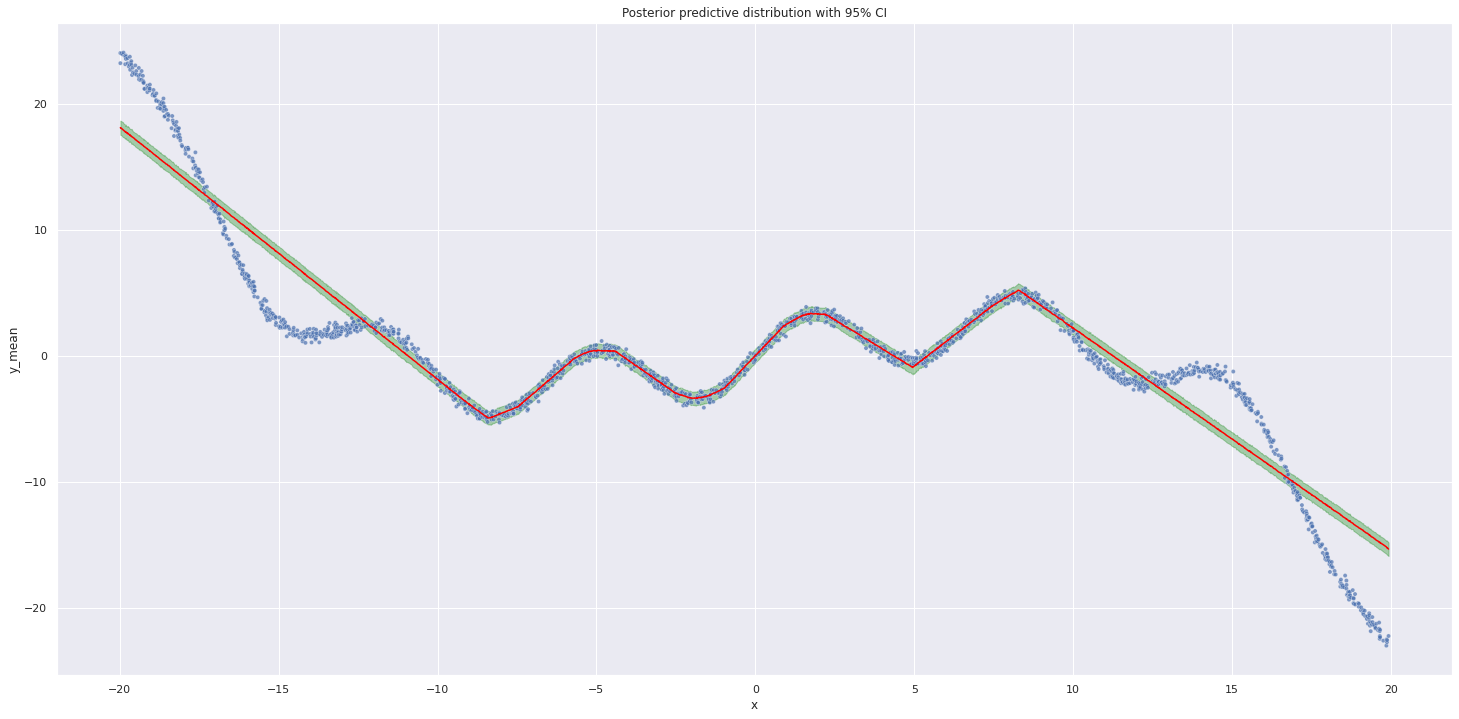

In [15]:
plot_predictions(train_pred_sorted, SAVE_PATH=f"{BASE_DIR}/1d_train_predictions.png")
plot_predictions(test_pred_sorted, SAVE_PATH=f"{BASE_DIR}/1d_test_predictions.png")

using device: cpu
====== evaluating profile prodlin-(10,20)-delta ======


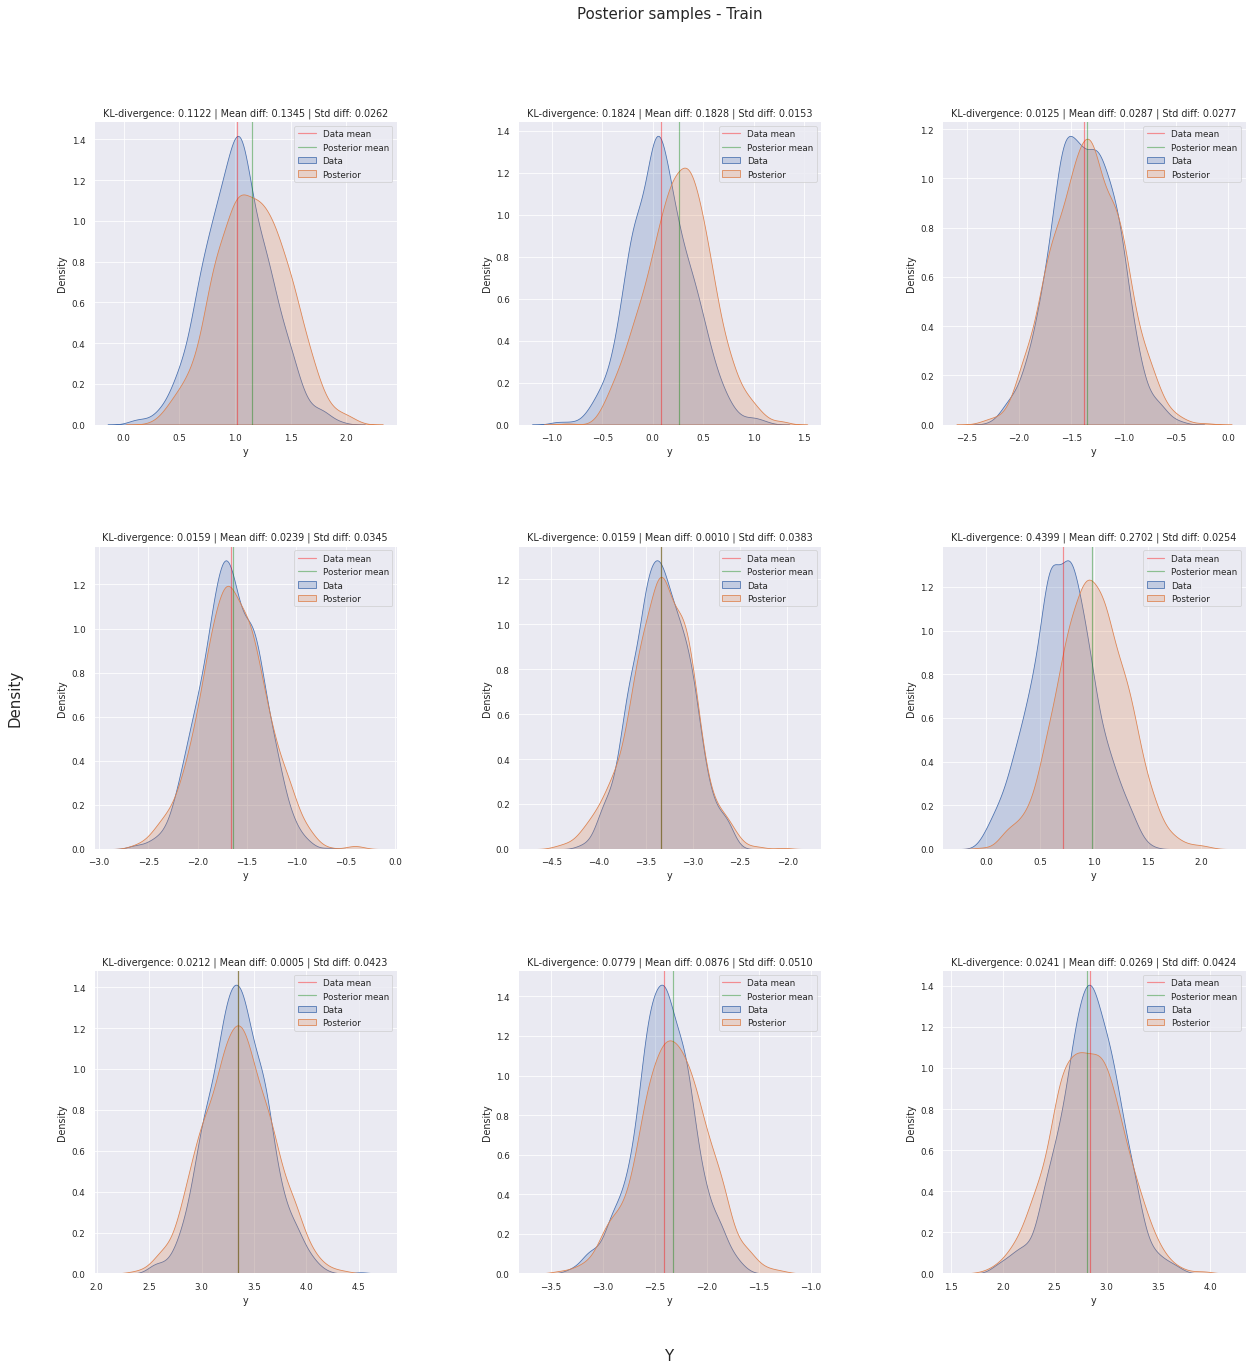

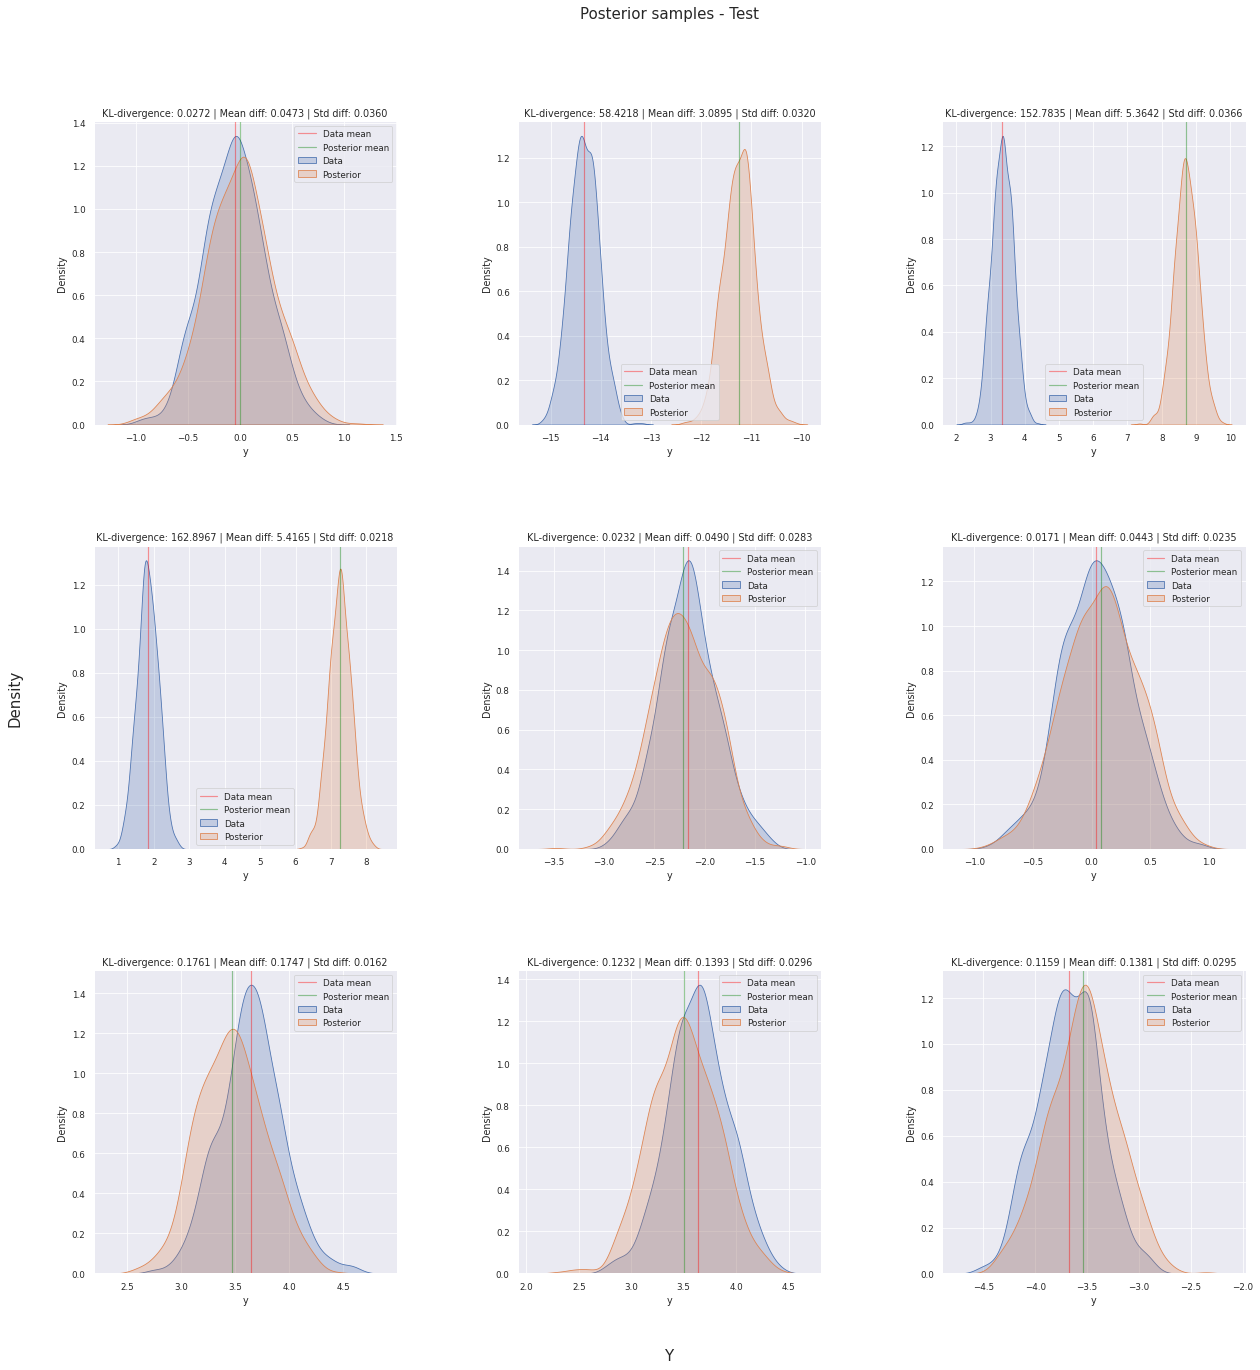

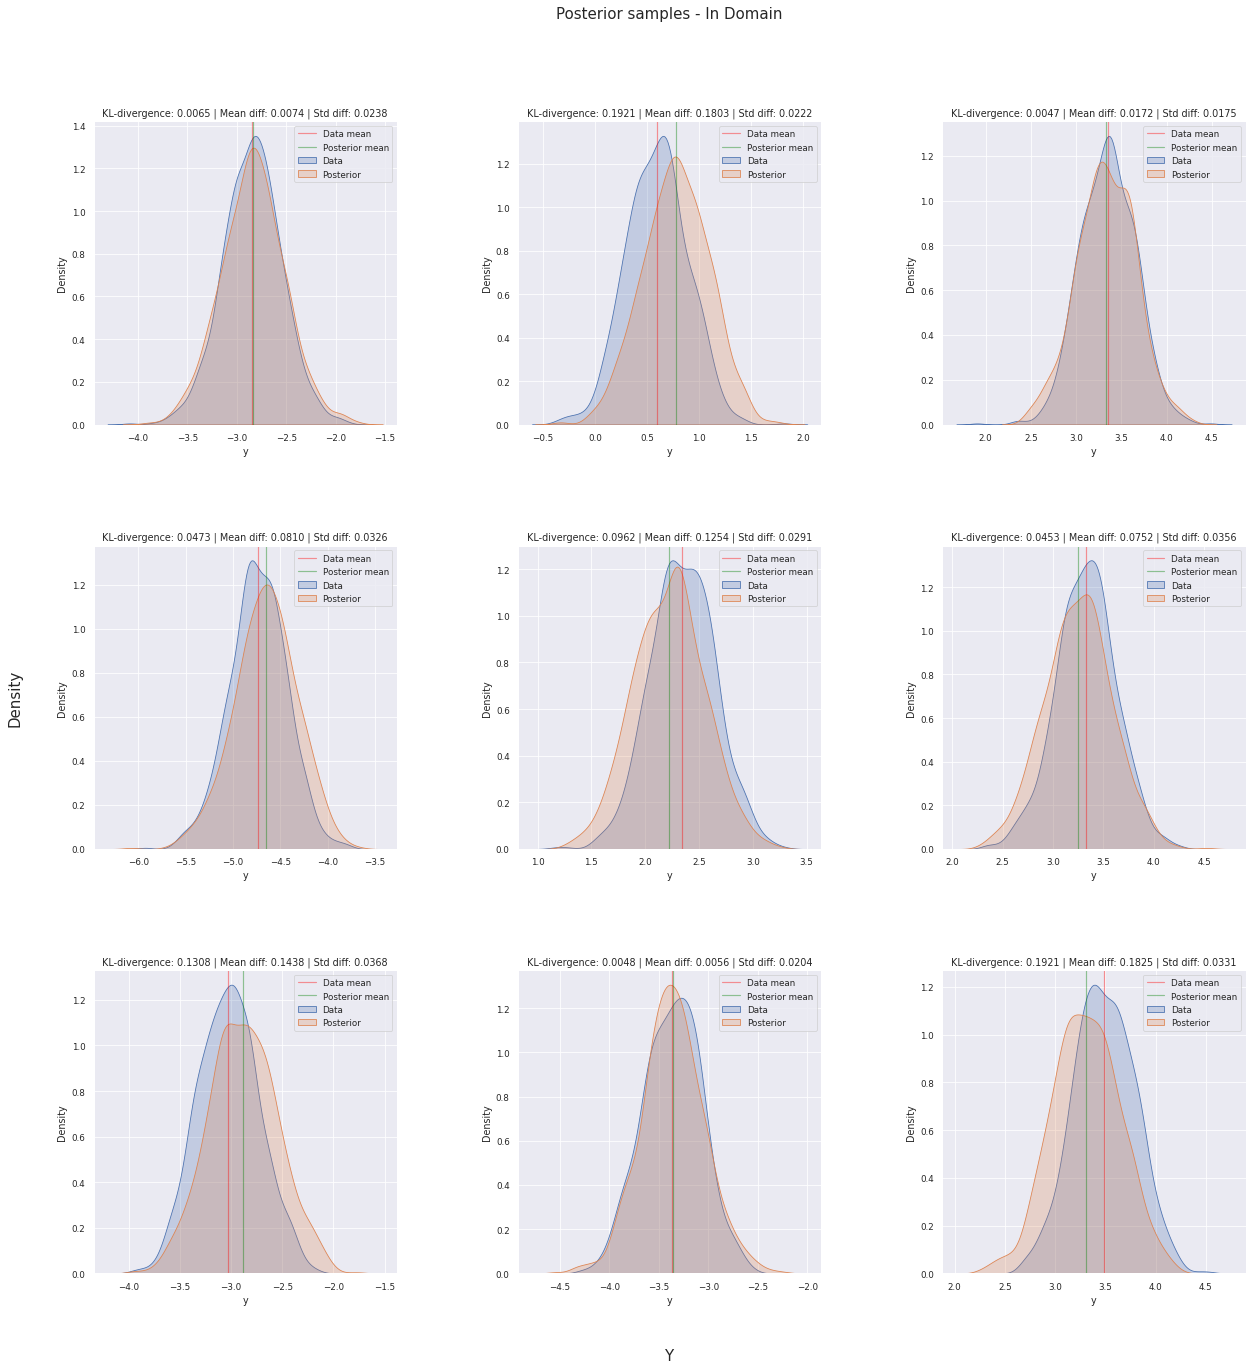

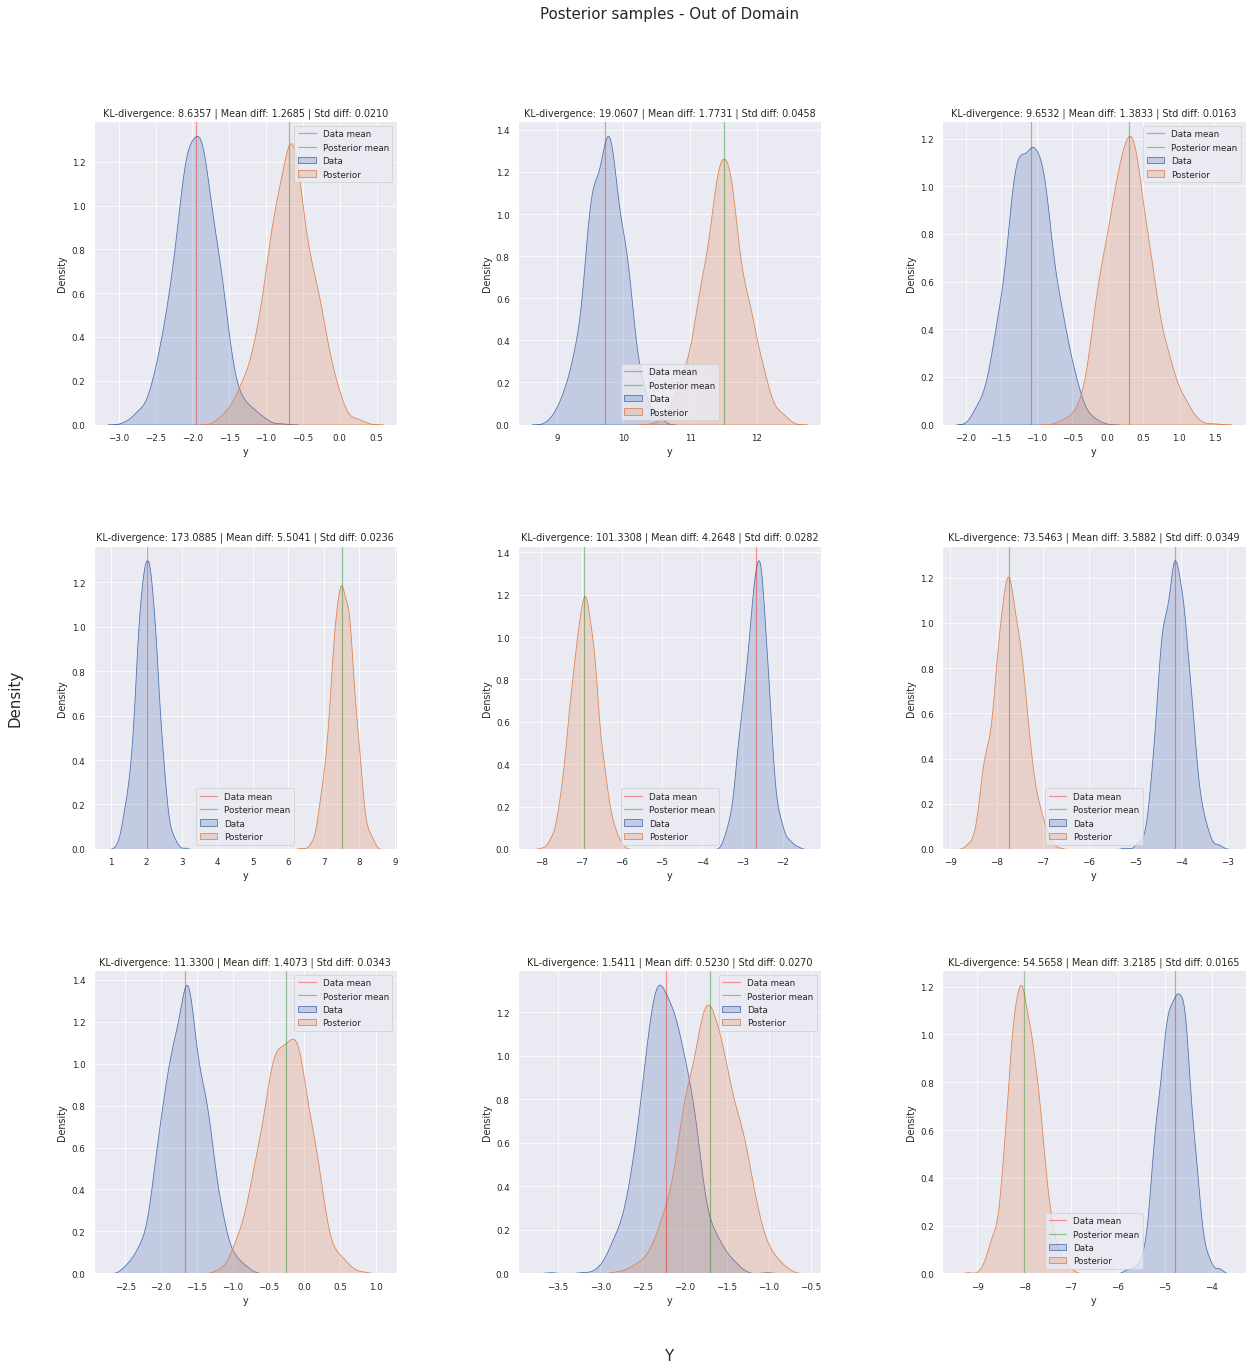

Eval done in 0:00:19.544057


In [16]:
if True:
            if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")

            eval.eval(config, dataset_config, f"{BASE_DIR}", inference_model=inference_model)

In [18]:
inference_model.guide

AutoDelta(
  (fc): PyroModule(
    (0): PyroModule(
      (0): PyroModule(
        (linear): PyroModule()
      )
    )
    (1): PyroModule(
      (linear): PyroModule()
    )
  )
)

In [23]:
pyro.get_param_store()["AutoDelta.fc.0.0.linear.weight"]

Parameter containing:
tensor([[-4.1309e-02],
        [ 4.2387e-01],
        [-8.3565e-01],
        [ 4.4159e-01],
        [-1.9954e-01],
        [ 6.4393e-01],
        [ 1.2556e+00],
        [-7.8529e-01],
        [-9.0015e-01],
        [ 8.4570e-01],
        [-8.9201e-01],
        [-5.8381e-01],
        [-2.0459e-43],
        [-6.4974e-01],
        [ 6.1657e-43],
        [-1.2189e-01],
        [-2.5891e-01],
        [-1.2622e+00],
        [-3.9937e-43],
        [-1.3600e+00],
        [-1.1376e-01],
        [ 1.9198e-43],
        [ 1.6141e-02],
        [-3.8967e-01],
        [ 2.0879e-43],
        [ 9.0825e-01],
        [-7.2063e-01],
        [ 7.8972e-01],
        [ 2.8472e-01],
        [-1.3873e-43],
        [-9.7973e-01],
        [ 1.1997e+00]], requires_grad=True)

In [26]:
pyro.get_param_store().keys()

dict_keys(['AutoDelta.fc.0.0.linear.weight', 'AutoDelta.fc.0.0.linear.bias', 'AutoDelta.fc.1.linear.weight', 'AutoDelta.fc.1.linear.bias', 'AutoDelta.sigma'])

In [27]:
inference_model.guide

AutoDelta(
  (fc): PyroModule(
    (0): PyroModule(
      (0): PyroModule(
        (linear): PyroModule()
      )
    )
    (1): PyroModule(
      (linear): PyroModule()
    )
  )
)